In [1]:
#!/bin/bash
!curl -L -o default-of-credit-card-clients-dataset.zip https://www.kaggle.com/api/v1/datasets/download/uciml/default-of-credit-card-clients-dataset
!unzip default-of-credit-card-clients-dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1001k  100 1001k    0     0  1583k      0 --:--:-- --:--:-- --:--:-- 1583k
Archive:  default-of-credit-card-clients-dataset.zip
  inflating: UCI_Credit_Card.csv     


In [2]:
import pandas as pd

data = pd.read_csv('UCI_Credit_Card.csv')
data.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [3]:
from sklearn.model_selection import train_test_split

X = data.drop('default.payment.next.month', axis=1)
y = data['default.payment.next.month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
Aplique um PCA de 4 componentes aos dados. Faça um downsampling nos dados devido ao desbalanço na variável resposta. Faça o tratamento dos dados com o one hot encoding e normalização para as devidas colunas. Treine os modelos Random Forest, SVM e MLP nos dados de treino X e y. Execute um grid search para todos os modelos, comparando a acurácia entre eles. Por fim, crie um arquivo pickle para cada modelo gerado. Faça tudo isso utilizando os pipelines do sklearn

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from imblearn.under_sampling import RandomUnderSampler
import pickle

# Assuming X_train, X_test, y_train, y_test are already defined from the previous code block

# Define numerical and categorical features
numerical_features = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                     'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# Create transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


# Create pipelines for each model
# The RandomUnderSampler is moved outside the main pipeline and will be applied before fitting
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('pca', PCA(n_components=4)),
                              ('classifier', RandomForestClassifier(random_state=42))])


pipeline_svm = Pipeline(steps=[('preprocessor', preprocessor),
                               ('pca', PCA(n_components=4)),
                               ('classifier', SVC(random_state=42))])


pipeline_mlp = Pipeline(steps=[('preprocessor', preprocessor),
                               ('pca', PCA(n_components=4)),
                               ('classifier', MLPClassifier(random_state=42, max_iter=500))])


# Define parameter grids for each model
param_grid_rf = {'classifier__n_estimators': [50, 100, 200],
                 'classifier__max_depth': [None, 10, 20]}

param_grid_svm = {'classifier__C': [0.1, 1, 10],
                  'classifier__gamma': [0.001, 0.01, 0.1]}

param_grid_mlp = {'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
                  'classifier__alpha': [0.0001, 0.001, 0.01]}


# Perform GridSearchCV for each model
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='accuracy')
grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=5, scoring='accuracy')
grid_search_mlp = GridSearchCV(pipeline_mlp, param_grid_mlp, cv=5, scoring='accuracy')

# Apply RandomUnderSampler before fitting the models
# Resample the training data using RandomUnderSampler
sampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

# Fit the models using the resampled data
grid_search_rf.fit(X_train_resampled, y_train_resampled)
grid_search_svm.fit(X_train_resampled, y_train_resampled)
grid_search_mlp.fit(X_train_resampled, y_train_resampled)


# Print the best parameters and accuracy for each model
print("Random Forest: Best parameters:", grid_search_rf.best_params_, "Best accuracy:", grid_search_rf.best_score_)
print("SVM: Best parameters:", grid_search_svm.best_params_, "Best accuracy:", grid_search_svm.best_score_)
print("MLP: Best parameters:", grid_search_mlp.best_params_, "Best accuracy:", grid_search_mlp.best_score_)


# Save the models to pickle files
pickle.dump(grid_search_rf.best_estimator_, open('random_forest_model.pkl', 'wb'))
pickle.dump(grid_search_svm.best_estimator_, open('svm_model.pkl', 'wb'))
pickle.dump(grid_search_mlp.best_estimator_, open('mlp_model.pkl', 'wb'))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Random Forest: Best parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 200} Best accuracy: 0.6392082509145999
SVM: Best parameters: {'classifier__C': 10, 'classifier__gamma': 0.1} Best accuracy: 0.6566786849167653
MLP: Best parameters: {'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (100,)} Best accuracy: 0.6645696694650445


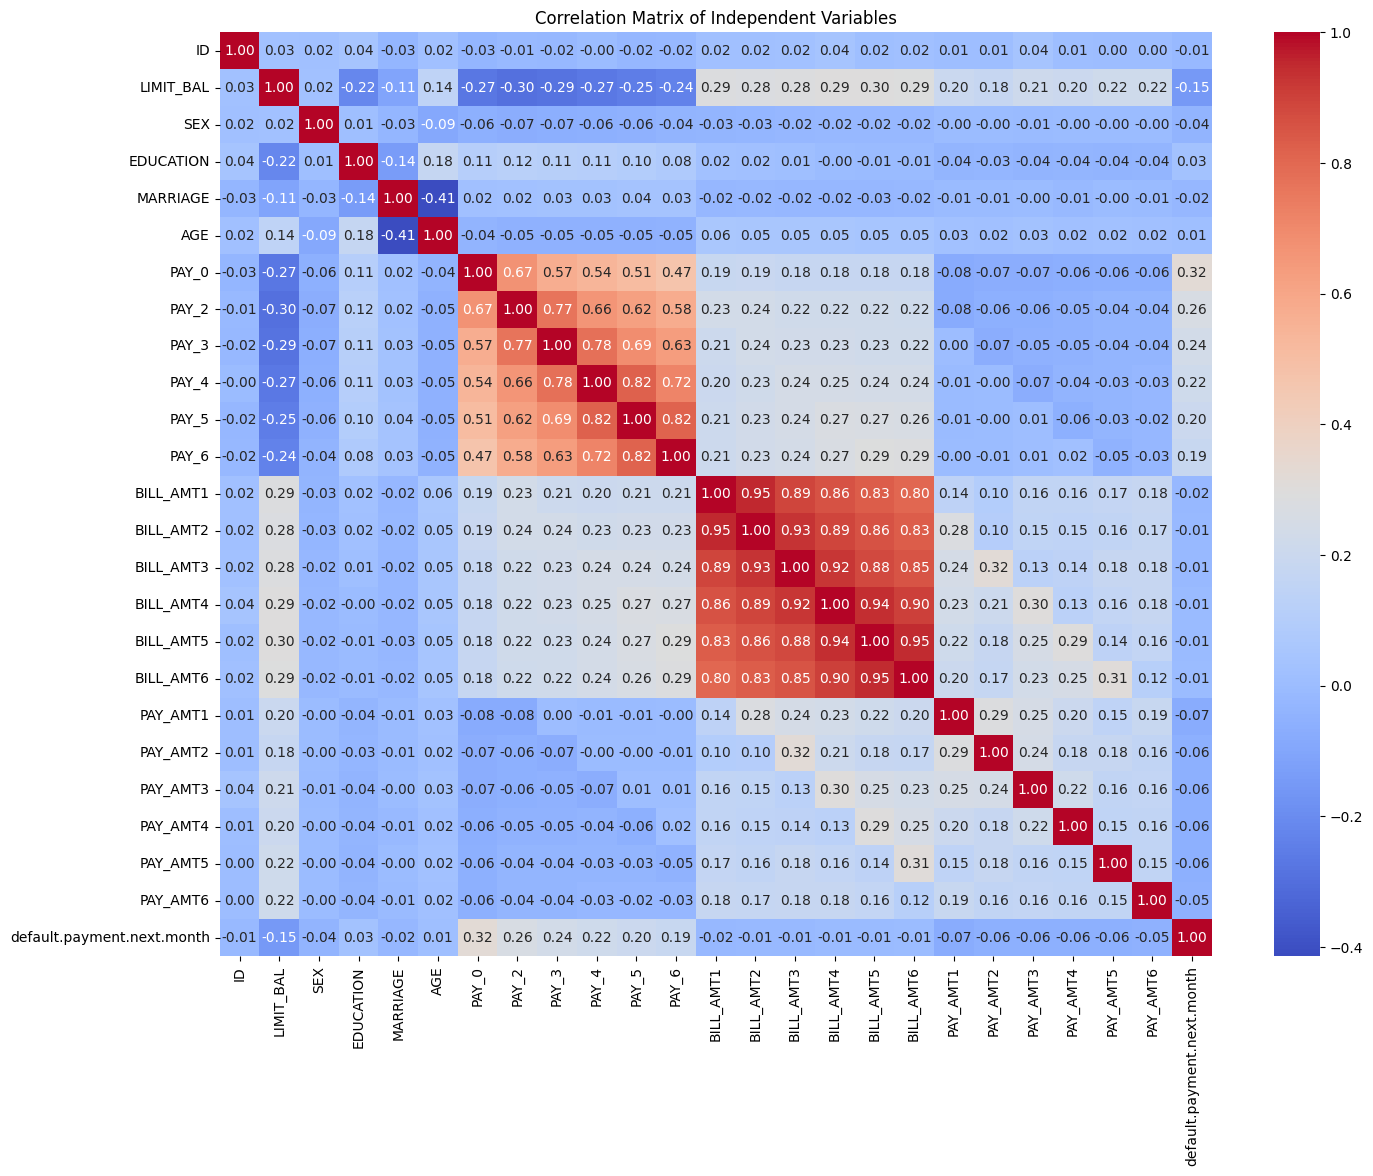

In [ ]:
# prompt: gere um plot para apresentar a correlação entre todas as variáveis independentes

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' DataFrame is already loaded from the previous code.
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Independent Variables')
plt.show()

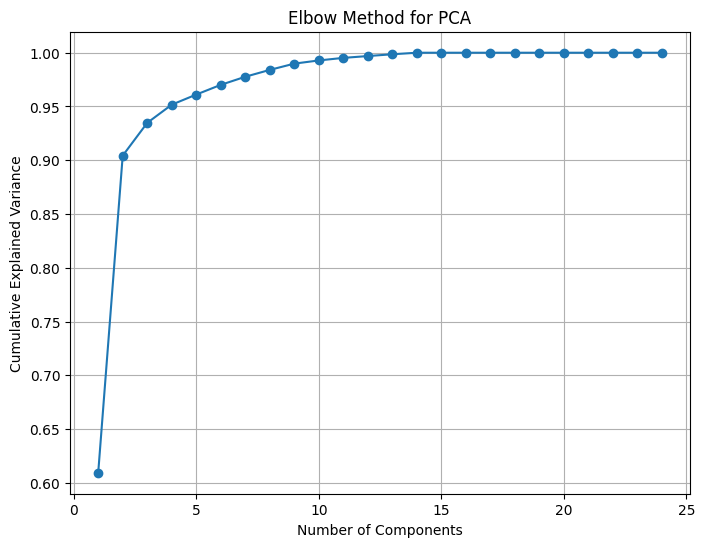

In [ ]:
# prompt: Ajuste um PCA na matriz X e faça o teste do cotovelo para avaliar o número de componentes ideal

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Assume X is your feature matrix (already defined in your code)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X)

# Explained Variance Ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Elbow method plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Elbow Method for PCA")
plt.grid(True)
plt.show()

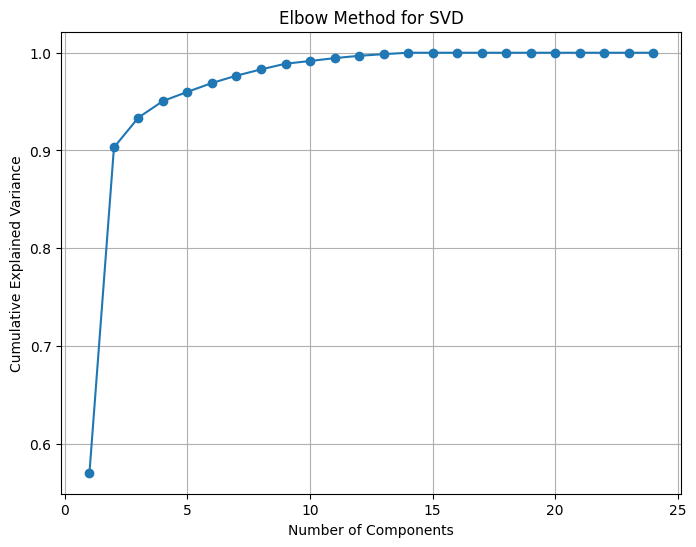

In [ ]:
# prompt: Ajuste um SVD na matriz X e faça o teste do cotovelo para avaliar o número de componentes ideal

from sklearn.decomposition import TruncatedSVD

# Assuming X_train_processed is your preprocessed data
svd = TruncatedSVD(X.shape[1]) # Initialize SVD with default parameters (you can adjust n_components as needed)
X_svd = svd.fit_transform(X)

# Explained Variance Ratio
explained_variance_ratio = svd.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Elbow method plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Elbow Method for SVD")
plt.grid(True)
plt.show()